In [63]:
import json
import requests
from requests_oauthlib import OAuth2Session
from oauthlib.oauth2 import BackendApplicationClient
import time
from datetime import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline

### Load credentials

In [64]:
with open("/home/guzzo/Software/credentials/twitch_app.json") as f:
    tcrets = json.load(f)
    client_id = tcrets['client_id']
    client_secret = tcrets['client_secret']
    redirect_uri =  tcrets['redirect_uri']

In [65]:
# Load token
with open("/home/guzzo/Software/credentials/twitch_token.json") as f:
    token = json.load(f)

In [66]:
# (datetime.fromtimestamp(token['expires_at']) - datetime.now()).days
from datetime import timedelta
timedelta(seconds=token['expires_in']).days

59

### Check the API works

In [67]:
# client = BackendApplicationClient(client_id=client_id, token=token)

oauth = OAuth2Session(
#     client=client,
    client_id=client_id,
    token=token,
)

In [68]:
base_url = "https://api.twitch.tv/helix/"
# base_url_v5 = "https://api.twitch.tv/kraken/"
streams_url = base_url+"streams/"

In [69]:
# New Twitch API
headers = {"Authorization": "Bearer {} https://api.twitch.tv/helix/".format(token['access_token'])}
# # # Twitch API v5
# headers_v5 = {
#     "Accept": "application/vnd.twitchtv.v5+json",
#     "Authorization": "OAuth {} https://api.twitch.tv/kraken/".format(token['access_token'])
# }

In [70]:
tresp = oauth.get(streams_url, headers=headers)

In [71]:
tresp.raise_for_status()
tresp.json()

{'data': [{'community_ids': [],
   'game_id': '29595',
   'id': '27385889952',
   'language': 'ru',
   'started_at': '2018-01-25T09:54:46Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_dota2ruhub2-{width}x{height}.jpg',
   'title': 'Newbee vs Liquid, ESL One Genting 2018, GodHunt & Inmate',
   'type': 'live',
   'user_id': '100815219',
   'viewer_count': 47426},
  {'community_ids': [],
   'game_id': '29595',
   'id': '27385908832',
   'language': 'en',
   'started_at': '2018-01-25T09:59:37Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_admiralbulldog-{width}x{height}.jpg',
   'title': 'Liquid vs Newbee PogChamp | [A] @AdmiralBulldog',
   'type': 'live',
   'user_id': '30816637',
   'viewer_count': 22662},
  {'community_ids': [],
   'game_id': '21779',
   'id': '27385373520',
   'language': 'en',
   'started_at': '2018-01-25T07:41:21Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_lck1-{width}x{height}

In [72]:
resp = oauth.get(streams_url, headers=headers)
# resp.raise_for_status()
resp.json()

{'data': [{'community_ids': [],
   'game_id': '29595',
   'id': '27385889952',
   'language': 'ru',
   'started_at': '2018-01-25T09:54:46Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_dota2ruhub2-{width}x{height}.jpg',
   'title': 'Newbee vs Liquid, ESL One Genting 2018, GodHunt & Inmate',
   'type': 'live',
   'user_id': '100815219',
   'viewer_count': 49328},
  {'community_ids': [],
   'game_id': '21779',
   'id': '27385373520',
   'language': 'en',
   'started_at': '2018-01-25T07:41:21Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_lck1-{width}x{height}.jpg',
   'title': 'LCK Spring: ROX vs. KDM - KSV vs. AFS',
   'type': 'live',
   'user_id': '124425501',
   'viewer_count': 24110},
  {'community_ids': [],
   'game_id': '29595',
   'id': '27385908832',
   'language': 'en',
   'started_at': '2018-01-25T09:59:37Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_admiralbulldog-{width}x{height}.jpg',
  

In [73]:
resp.headers

{'Content-Type': 'application/json; charset=utf-8', 'Server': 'nginx', 'Access-Control-Allow-Origin': '*', 'Cache-Control': 'no-cache, no-store, must-revalidate, private', 'Expires': '0', 'Pragma': 'no-cache', 'Ratelimit-Limit': '120', 'Ratelimit-Remaining': '118', 'Ratelimit-Reset': '1516885980', 'Twitch-Trace-Id': 'a2d113ea2d91e98fce3cdc8b9aa88368', 'X-Ctxlog-Logid': '1-5a69d7a1-1e041580785e729948145d2f', 'Front-End-Https': 'on', 'Timing-Allow-Origin': 'https://www.twitch.tv', 'Vary': 'Accept-Encoding', 'Date': 'Thu, 25 Jan 2018 13:12:01 GMT', 'Content-Length': '7129', 'Connection': 'keep-alive', 'Set-Cookie': 'AWSALB=tOasPsHl66UqlB5eJ8RbaKPhHrZ3ijzhikSRfqR6r+cJKS8fsU4BpcbIDJs1fk1uoBzhf3t/xFoNsAM9jL5bgue7dq7rn5KzU7CGRY53vtVDFA16egS4EW9cBNOt; Expires=Thu, 01 Feb 2018 13:12:01 GMT; Path=/'}

In [74]:
resp.raise_for_status()

### Start crawling streams

In [75]:
user_ids = set()

In [76]:
done = False
page = None
params = {}
while not done:
    if page:
        params = dict(
            after=page,
        )
    response_streams = oauth.get(streams_url, headers=headers, params=params)
    try:
        response_streams.raise_for_status()
    except requests.exceptions.HTTPError as e:
        raise
    
    page = response_streams.json()['pagination']['cursor']
    for d in response_streams.json()['data']:
        user_ids.add(d.get('user_id'))
    print("IDs found :", len(user_ids))
    
    try:
        if int(response_streams.json()['data'][-1]['viewer_count']) <= 100:
            print("We're done. Bye.")
            done = True
    except Exception as e:
        print(e)
    
    hds = response_streams.headers
#     break
    if int(hds['Ratelimit-Remaining']) == 0:
        delay = int(
            hds['Ratelimit-Reset']
        ) - datetime.timestamp(datetime.now())
        print("Ratelimit reached. Sleeping {} secs...".format(delay))
        time.sleep(delay)

IDs found : 20
IDs found : 39
IDs found : 59
IDs found : 79
IDs found : 99
IDs found : 119
IDs found : 139
IDs found : 159
IDs found : 179
IDs found : 198
IDs found : 218
IDs found : 238
IDs found : 258
IDs found : 278
IDs found : 298
IDs found : 318
IDs found : 338
IDs found : 358
IDs found : 378
IDs found : 398
IDs found : 418
IDs found : 438
IDs found : 454
IDs found : 470
IDs found : 490
IDs found : 510
IDs found : 530
IDs found : 548
IDs found : 568
IDs found : 588
IDs found : 608
IDs found : 628
IDs found : 648
IDs found : 668
IDs found : 688
IDs found : 708
IDs found : 728
IDs found : 748
IDs found : 768
We're done. Bye.


In [77]:
# datetime.fromtimestamp(int(response_streams.headers['Ratelimit-Reset']))
response_streams = oauth.get(streams_url, headers=headers, params=params)

In [78]:
# datetime.now()
response_streams.json()

{'data': [{'community_ids': ['015516d8-18dc-417f-8b3d-6774f4a4e871',
    '558ffafb-6f75-44ff-8cb7-a4f045d2399f',
    'f7fd59cd-3da5-4cf6-9d59-1fb3a5238879'],
   'game_id': '33214',
   'id': '27385438192',
   'language': 'en',
   'started_at': '2018-01-25T07:57:51Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_oneaway_-{width}x{height}.jpg',
   'title': 'NEW UPDATE! ITS LIT! 😊 Song Request On! 🎶📻',
   'type': 'live',
   'user_id': '43310047',
   'viewer_count': 101},
  {'community_ids': ['848d95be-90b3-44a5-b143-6e373754c382',
    'fd0eab99-832a-4d7e-8cc0-04d73deb2e54',
    'ff1e77af-551d-4993-945c-f8ceaa2a2829'],
   'game_id': '460636',
   'id': '27384812464',
   'language': 'en',
   'started_at': '2018-01-25T05:38:13Z',
   'thumbnail_url': 'https://static-cdn.jtvnw.net/previews-ttv/live_user_apdrop-{width}x{height}.jpg',
   'title': 'dropPeek | 1st Bloodborne Playthrough(1st souls game) dropBlind | @apdrop',
   'type': 'live',
   'user_id': '32560951',
   

In [79]:
len(user_ids)

768

### Get new user_id from user follows

In [124]:
follows_url = "https://api.twitch.tv/helix/users/follows"

In [125]:
_uid = 59189673
params = {
#     "to_id": 17337557,
    "from_id": _uid,
    "first": 100,
}

In [126]:
r_foll = oauth.get(follows_url, headers=headers, params=params)

In [127]:
print([i for i in range(99 // 100)])

[]


In [136]:
r_foll.json()['data']

[{'followed_at': '2018-01-23T00:48:21Z',
  'from_id': '59189673',
  'to_id': '26560695'},
 {'followed_at': '2017-11-07T16:45:24Z',
  'from_id': '59189673',
  'to_id': '57292293'},
 {'followed_at': '2017-10-29T23:02:38Z',
  'from_id': '59189673',
  'to_id': '26301881'},
 {'followed_at': '2017-10-23T14:25:14Z',
  'from_id': '59189673',
  'to_id': '93479223'},
 {'followed_at': '2017-09-01T23:35:44Z',
  'from_id': '59189673',
  'to_id': '38446500'},
 {'followed_at': '2017-08-22T23:48:38Z',
  'from_id': '59189673',
  'to_id': '147798060'},
 {'followed_at': '2017-08-15T17:33:23Z',
  'from_id': '59189673',
  'to_id': '42673406'},
 {'followed_at': '2017-07-31T13:01:45Z',
  'from_id': '59189673',
  'to_id': '130173808'},
 {'followed_at': '2017-06-11T03:09:00Z',
  'from_id': '59189673',
  'to_id': '31778135'},
 {'followed_at': '2017-06-01T19:42:42Z',
  'from_id': '59189673',
  'to_id': '68733428'},
 {'followed_at': '2017-02-22T18:41:54Z',
  'from_id': '59189673',
  'to_id': '90407832'},
 {'follo

In [130]:
oauth.params = {
#     "to_id": 17337557,
    "from_id": _uid,
    "first": 100,
}
oauth.params.update(dict(after='eyJiIjpudWxsLCJhIjoiMTM5Nzc5NzExOTk1MDI3MzAwMCJ9'))
r_foll2 = oauth.get(follows_url, headers=headers)

In [132]:
r_foll2.json()

{'data': [], 'pagination': {'cursor': 'eyJiIjpudWxsLCJhIjoiIn0'}, 'total': 100}

In [85]:
done = False
page = None

# while not done:
for _uid in list(user_ids):
    params = {
        #     "to_id": 17337557,
#         "to_id": _uid,
        "from_id": _uid,
        "first": 100,
    }
        
    response_follows = oauth.get(follows_url, headers=headers, params=params)
    
    try:
        response_follows.raise_for_status()
    except requests.exceptions.HTTPError as e:
        raise
        
    json_payload = response_follows.json()
    if json_payload['total'] > 100:
        page = json_payload['pagination']['cursor']
    else:
        page = None
    for _ in range(int(json_payload['total']) // 100):
        params['after'] = page
        response_follows = oauth.get(follows_url, headers=headers, params=params)
        
        for d in response_follows.json()['data']:
            user_ids.add(d.get('from_id'))
        print("IDs found :", len(user_ids))
    
        hds = response_follows.headers
    #     break
        if int(hds['Ratelimit-Remaining']) == 0:
            delay = int(
                hds['Ratelimit-Reset']
            ) - datetime.timestamp(datetime.now())
            print("Ratelimit reached. Sleeping {} secs...".format(delay))
            time.sleep(delay+1)
    if page:
        del params['after']

IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
Ratelimit reached. Sleeping 55.41684603691101 secs...
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
IDs found : 768
ID

HTTPError: 429 Client Error: Too Many Requests for url: https://api.twitch.tv/helix/users/follows?from_id=56152467&first=100

In [86]:
response_follows.json()
# len(user_ids)

{'error': 'Too Many Requests',
 'message': 'You were going so fast that you traveled back in time',
 'status': 429}

### Find top users in current set

Let's select the top 1000 users sorting by total views.

In [87]:
users_url = "https://api.twitch.tv/helix/users"

In [88]:
users = {}
# from itertools import islice

In [89]:
params = {
    "id": list(user_ids)[:100]
}
response_users = oauth.get(users_url, headers=headers, params=params)
response_users.json()['data'][0]

{'broadcaster_type': 'partner',
 'description': '이름 : 안병영닉네임 : 뱅붕나이 : 30살성경험 : 없음방송 : 종합게임전문방송',
 'display_name': '뱅붕',
 'id': '108655405',
 'login': 'dou3796',
 'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/dou3796-channel_offline_image-6a74e577cb792c57-1920x1080.jpeg',
 'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/9de3a592-a92f-4829-9fa3-d5d62c96d220-profile_image-300x300.jpg',
 'type': '',
 'view_count': 2657569}

In [90]:
from typing import NamedTuple
class User(NamedTuple):
    broadcaster_type: str
    description: str
    display_name: str
    id: str
    login: str
    offline_image_url: str
    profile_image_url: str
    type: str
    view_count: int
    email: str = ''

In [91]:
t_u = User(
    **response_users.json()['data'][0]
    )
print(t_u._asdict())
t_u.id

OrderedDict([('broadcaster_type', 'partner'), ('description', '이름 : 안병영닉네임 : 뱅붕나이 : 30살성경험 : 없음방송 : 종합게임전문방송'), ('display_name', '뱅붕'), ('id', '108655405'), ('login', 'dou3796'), ('offline_image_url', 'https://static-cdn.jtvnw.net/jtv_user_pictures/dou3796-channel_offline_image-6a74e577cb792c57-1920x1080.jpeg'), ('profile_image_url', 'https://static-cdn.jtvnw.net/jtv_user_pictures/9de3a592-a92f-4829-9fa3-d5d62c96d220-profile_image-300x300.jpg'), ('type', ''), ('view_count', 2657569), ('email', '')])


'108655405'

In [92]:
# [
#     (len(l[i:i+100]), i+100) for i in range(0, len(user_ids), 100)
# ][-3:]
l = list(user_ids)
for i in range(0, len(user_ids), 100):
    params = {
        "id": l[i:i+100]
    }
    response_users = oauth.get(users_url, headers=headers, params=params)
    try:
        response_users.raise_for_status()
    except requests.exceptions.HTTPError as e:
        raise
    data = response_users.json()['data']
    for d in data:
        d['timestamp'] = datetime.timestamp(datetime.now())
        users[d['id']] = d
        
    if (i+100) % 1000 == 0:
        print("{} users processed.".format(i+100))

    hds = response_users.headers
    
    if int(hds['Ratelimit-Remaining']) == 0:
        delay = int(
            hds['Ratelimit-Reset']
        ) - datetime.timestamp(datetime.now())
        print("Ratelimit reached. Sleeping {} secs...".format(delay))
        time.sleep(delay+1)

In [93]:
len(users)
# datetime.timestamp(datetime.now())

768

In [94]:
import pandas as pd

In [95]:
df = pd.DataFrame().from_dict(users, orient='index')
# df.from_dict()

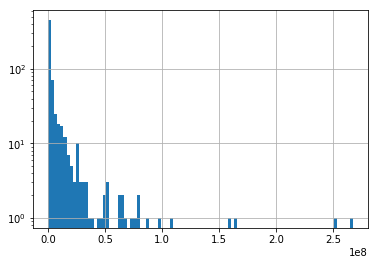

In [115]:
df.view_count[df.view_count > 100000].hist(bins=100)
plt.yscale('log')
# plt.plot()

In [123]:
# df[df.view_count>1000].info()
# df[df.broadcaster_type != ''].sort_values('view_count', ascending=False).head(100)
# df[df.broadcaster_type != ''].shape
# df.broadcaster_type.unique()

In [98]:
df.head()

id          login   display_name type broadcaster_type  \
100048373  100048373     taesangyun             태상               partner   
100449350  100449350   capta1n_pony             포니               partner   
100815219  100815219    dota2ruhub2    Dota2ruhub2               partner   
100896181  100896181       niniko_w             妮妮               partner   
100958619  100958619  liquidatorwot  liquidatorWOT               partner   

                              description  \
100048373      Korean hearthstone player.   
100449350  안녕하세요. LoL 랭크 방송과 콘솔게임 방송합니다.    
100815219                                   
100896181      Hello! 叫我妮妮就可以了(๑•́ ₃ •̀๑)   
100958619                   liquidatorWOT   

                                           profile_image_url  \
100048373  https://static-cdn.jtvnw.net/jtv_user_pictures...   
100449350  https://static-cdn.jtvnw.net/jtv_user_pictures...   
100815219  https://static-cdn.jtvnw.net/jtv_user_pictures...   
100896181  https://static-cdn.jtvnw.net/jtv_user_pictures...   
100958619  https://static-cdn.jtvnw.net/jtv_user_pictures...   

                                           offline_image_url  view_count  \
100048373  https://static-cdn.jtvnw.net/jtv_user_pictures...     2137263   
100449350                                                        1585810   
100815219  https://static-cdn.jtvnw.net/jtv_user_pictures...    19002613   
100896181  https://static-cdn.jtvnw.net/jtv_user_pictures...     3690292   
100958619                                                         628390   

              timestamp  
100048373  1.516886e+09  
100449350  1.516886e+09  
100815219  1.516886e+09  
100896181  1.516886e+09  
100958619  1.516886e+09

### SQLite test

In [281]:
import sqlite3
conn = sqlite3.connect('users_test.db')

In [ ]:
curs = conn.cursor()
# users.values()
curs.execute('''CREATE TABLE users
(broadcaster_type text,
    description text,
    display_name text
    id text,
    login text,
    offline_image_url text,
    profile_image_url text,
    type text,
    view_count integer)
'''
)

In [304]:
conn.commit()

In [301]:
# curs.execute('''DROP TABLE users''')

In [308]:
curs.executemany('''INSERT INTO users VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)''', users.values())

In [305]:
for row in curs.execute('''SELECT * FROM users'''):
    print(row)

In [298]:
# curs.fetchall()

[]

In [306]:
users

{'186149410': {'broadcaster_type': '',
  'description': 'tommy walnut drop me a follow haha !',
  'display_name': 'tommywalnut',
  'id': '186149410',
  'login': 'tommywalnut',
  'offline_image_url': '',
  'profile_image_url': 'https://static-cdn.jtvnw.net/user-default-pictures/b83b1794-7df9-4878-916c-88c2ad2e4f9f-profile_image-300x300.jpg',
  'timestamp': 1516057561.613212,
  'type': '',
  'view_count': 68},
 '101259028': {'broadcaster_type': '',
  'description': 'Scemo chi legge 1!1!!1!1111!1!1!!1!!!1',
  'display_name': 'fsf_ita',
  'id': '101259028',
  'login': 'fsf_ita',
  'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/01edb004e6aa1bc6-channel_offline_image-1920x1080.jpeg',
  'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/10ab70a6-d29b-46ed-8219-d071c97472cb-profile_image-300x300.png',
  'timestamp': 1516057561.613231,
  'type': '',
  'view_count': 2603},
 '153386131': {'broadcaster_type': '',
  'description': '嗨，我是Nino，我175公分。',
  'displ

In [309]:
import pickle

In [312]:
with open("users.pkl", 'wb') as f:
    pickle.dump(users, f)

In [314]:
with open('users.pkl', 'rb') as f:
    test = pickle.load(f)

In [315]:
test

{'186149410': {'broadcaster_type': '',
  'description': 'tommy walnut drop me a follow haha !',
  'display_name': 'tommywalnut',
  'id': '186149410',
  'login': 'tommywalnut',
  'offline_image_url': '',
  'profile_image_url': 'https://static-cdn.jtvnw.net/user-default-pictures/b83b1794-7df9-4878-916c-88c2ad2e4f9f-profile_image-300x300.jpg',
  'timestamp': 1516057561.613212,
  'type': '',
  'view_count': 68},
 '101259028': {'broadcaster_type': '',
  'description': 'Scemo chi legge 1!1!!1!1111!1!1!!1!!!1',
  'display_name': 'fsf_ita',
  'id': '101259028',
  'login': 'fsf_ita',
  'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/01edb004e6aa1bc6-channel_offline_image-1920x1080.jpeg',
  'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/10ab70a6-d29b-46ed-8219-d071c97472cb-profile_image-300x300.png',
  'timestamp': 1516057561.613231,
  'type': '',
  'view_count': 2603},
 '153386131': {'broadcaster_type': '',
  'description': '嗨，我是Nino，我175公分。',
  'displ

In [318]:
resp = oauth.get(users_url, headers=headers, params={'login': 'rockynohands'})

In [325]:
int(resp.json()['data'][0]['id']) in user_ids

False